In [2]:
from einops import rearrange, repeat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms

from imageclassification import prepare_dataloaders, set_seed
from vit import ViT, positional_encoding_2d

def image_to_patches(image, patch_size, image_grid=True):
    """
        image : torch.Tensor of shape B x C x H x W
        patch_size : number of pixels per dimension of the patches (tuple)
        image_grid : If True, the patches are returned as an image grid.
                     else they are return as a sequence of flattened patches
                     B x num_patches x (patch_h * patch_w * C)
    """
    # image shape: B x C x H x W 
    # same as B x C x (num_patches_h * patch_h) x (num_patches_w * patch_w)
    # where num_patches_h = (H // patch_h) and num_patches_w = (W // patch_w)
    # and num_patches = num_patches_h * num_patches_w
    B, C, H, W = image.shape        
    patch_h, patch_w = patch_size
    assert H % patch_h == 0 and W % patch_w == 0, 'image dimensions must be divisible by the patch size.'
    num_patches = (H // patch_h) * (W // patch_w)

    if image_grid:
        print(f'number of patches: {num_patches}')
        """
        Split H and W to pathces
        HINT: B x c x H x W to B x C x num_patches_h x patch_h x num_patches_w x patch_w
        where H = num_patches_h * patch_h, W=num_patches_w * patch_w to
        """
        patches = rearrange(image,"B C (NP_h patch_h) (NP_w patch_w) -> B C NP_h patch_h NP_w patch_w",NP_h=(H // patch_h),patch_h = patch_h,NP_w = (W//patch_w),patch_w=patch_w)

        """
        Create num_patches_h*num_patches_w images of size patch_h x patch_w
        HINT: B x C x num_patches_h x patch_h x num_patches_w x patch_w -> 
            B x (num_patches_h*num_patches_w ) x C x patch_h x patch_w
        """
        print("Running second op")
        patches = rearrange(patches,"B C num_patches_h patch_h num_patches_w patch_w -> B (num_patches_h num_patches_w) C patch_h patch_w")
    else:
        """
        Again split the image to patches but flatten each patch. 
        Output Dimensions should be: 
        B x (num_patches_h*num_patches_w ) x (C ( patch_h * patch_w)
        """
        patches = rearrange(image,"B C (NP_h patch_h) (NP_w patch_w) -> B C NP_h patch_h NP_w patch_w",NP_h=(H // patch_h),patch_h = patch_h,NP_w = (W//patch_w),patch_w=patch_w)
        patches = rearrange(patches,"B C num_patches_h patch_h num_patches_w patch_w -> B (num_patches_h num_patches_w) (C patch_h patch_w)")
        assert patches.size()== (batch_size, num_patches, (patch_h * patch_w * C))
    return patches

In [ ]:
# select 2 classes from CIFAR10
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 
batch_size = 8
classes = [3,7]
_, _, dataset, _ = prepare_dataloaders(batch_size=batch_size, classes=classes)


Files already downloaded and verified
Files already downloaded and verified


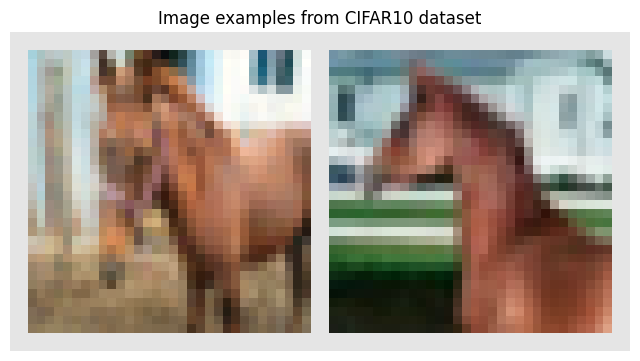

shape of input images (batch):  torch.Size([2, 3, 32, 32])
number of patches: 4
Running second op
shape of image patches:  torch.Size([2, 4, 3, 16, 16])


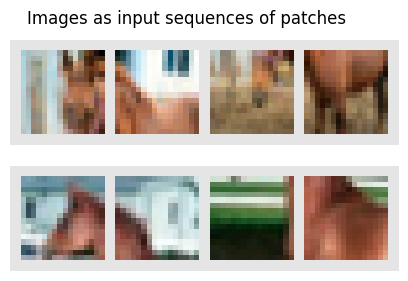

AssertionError: 

In [16]:

# visualize examples
example_images = torch.stack([dataset[idx][0] for idx in range(2)], dim=0) #range(batch_size)
img_grid = torchvision.utils.make_grid(example_images, nrow=batch_size, 
                                    normalize=True, pad_value=0.9
)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.title("Image examples from CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()

# convert images to patches
print(f'shape of input images (batch):  {example_images.shape}')
img_patches = image_to_patches(example_images, patch_size=(16,16), image_grid=True)
print(f'shape of image patches:  {img_patches.shape}')

# visualize patches
fig, ax = plt.subplots(example_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(example_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], 
                                        nrow=img_patches.shape[1], 
                                        normalize=True, pad_value=0.9
    )
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()

# test input patches before linear embedding layer
img_patches = image_to_patches(example_images, patch_size=(4,4), image_grid=False)
print(f'shape of input patches BEFORE the linear projection layer (batch): {img_patches.shape}')

# NOTE: DOES THIS PLOT PROVIDE ANY USEFUL INSIGHT?


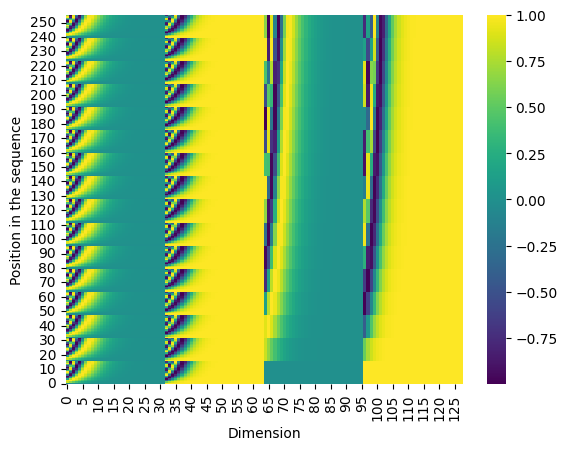

In [18]:
#plot positional_encoding_2d
H, W = (32, 32)
patch_h , patch_w = (4,4)

pos_embedding = positional_encoding_2d(
            nph = H // patch_h,
            npw = W // patch_w,
            dim = 128,
        ) 
sns.heatmap(pos_embedding.squeeze(0), cmap=sns.color_palette("viridis", as_cmap=True))
plt.xlabel('Dimension')
plt.ylabel('Position in the sequence')
plt.gca().invert_yaxis()
plt.show()